### Project Insight
The objective is to provide a macro-level characterization of the company's projects.

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [214]:
issue_custom_field_contexts = pd.read_excel('jira_issue_custom_field_contexts.xlsx')
issue_custom_field_options = pd.read_excel('jira_issue_custom_field_options.xlsx')
issue_fields = pd.read_excel('jira_issue_field.xlsx')
issue_types = pd.read_excel('jira_issue_types.xlsx')
issues = pd.read_excel('jira_issues.xlsx')
projects = pd.read_excel('jira_projects.xlsx')
sprint_issues = pd.read_excel('jira_sprint_issues.xlsx')
sprint = pd.read_excel('jira_sprints.xlsx')
users = pd.read_excel('jira_users.xlsx')
tempo_worklogs = pd.read_csv('query_result_v2.csv')

In [215]:
user_groups_detailed = pd.read_csv('jira_user_groups_detailed.csv')
#user_groups_detailed.info()
#user_groups_detailed.head()

In [216]:
#NETTOYAGE DE LA TABLE TEMPO_WORKLOGS 

# Extraire l'id issue de la colonne json 'issue' dans la table tempo et la nommer id_issue pour qu'elle ait le même noms que dans la table df_issues_projects
def safe_json_parse(json_str):
    try:
        if isinstance(json_str, str):
            return json.loads(json_str)
        elif isinstance(json_str, dict):
            return json_str
        else:
            return {}
    except json.JSONDecodeError:
        return {}

tempo_worklogs['issue'] = tempo_worklogs['issue'].apply(safe_json_parse)

tempo_worklogs['id_issue'] = tempo_worklogs['issue'].apply(lambda x: x.get('id') if isinstance(x, dict) else None)


#query pour extraire des données de la colonne json 'attributes' dans la table tempo
def safe_json_parse(json_str):
    try:
        if isinstance(json_str, str):
            return json.loads(json_str)
        elif isinstance(json_str, dict):
            return json_str
        else:
            return {}
    except json.JSONDecodeError:
        return {}

tempo_worklogs['attributes'] = tempo_worklogs['attributes'].apply(safe_json_parse)

tempo_worklogs['value'] = tempo_worklogs['attributes'].apply(lambda x: x.get('values') if isinstance(x, dict) else None)

#La nouvelle colonne contient une liste, dans laquelle il faut extraire de nouveau value pour avoir la colonne finale
def extract_value(x):
    if isinstance(x, str):
        try:
            # Convertir la chaîne en liste de dictionnaires
            lst = ast.literal_eval(x)
            if isinstance(lst, list) and len(lst) > 0:
                return lst[0].get('value', None)
        except:
            return None
    elif isinstance(x, list) and len(x) > 0:
        return x[0].get('value', None)
    return None

# Appliquer la fonction à la colonne 'value'
tempo_worklogs['value'] = tempo_worklogs['value'].apply(extract_value)

# Remplacer les valeurs None par 'Non spécifié'
tempo_worklogs['value'] = tempo_worklogs['value'].fillna('Non spécifié')


#query pour extraire des données de la colonne json 'author' dans la table tempo
def safe_json_parse(json_str):
    try:
        if isinstance(json_str, str):
            return json.loads(json_str)
        elif isinstance(json_str, dict):
            return json_str
        else:
            return {}
    except json.JSONDecodeError:
        return {}

tempo_worklogs['author'] = tempo_worklogs['author'].apply(safe_json_parse)

tempo_worklogs['accountId'] = tempo_worklogs['author'].apply(lambda x: x.get('accountId') if isinstance(x, dict) else None)

# drop les colonnes inutiles de tempo_worklogs
tempo_worklogs = tempo_worklogs.drop(["self", "createdAt", "updatedAt", "_airbyte_raw_id", "_airbyte_extracted_at", "_airbyte_meta", 'issue', 'author', 'attributes', 'startTime'], axis=1)

# transformer la colonne startDate en format datetime
tempo_worklogs['startDate'] = pd.to_datetime(tempo_worklogs['startDate'], errors='coerce')

#tempo_worklogs.head()
tempo_worklogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31032 entries, 0 to 31031
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   startDate         31032 non-null  datetime64[ns]
 1   description       31032 non-null  object        
 2   tempoWorklogId    31032 non-null  object        
 3   billableSeconds   31032 non-null  int64         
 4   timeSpentSeconds  31032 non-null  int64         
 5   id_issue          31032 non-null  int64         
 6   value             31032 non-null  object        
 7   accountId         31032 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 1.9+ MB


In [217]:
# PAS UTILE POUR L'ANALYSE

# query pour extraire des données de la colonne json 'schema' dans la table issue_fields
def safe_json_parse(json_str):
    try:
        if isinstance(json_str, str):
            return json.loads(json_str)
        elif isinstance(json_str, dict):
            return json_str
        else:
            return {}
    except json.JSONDecodeError:
        return {}

issue_fields['schema'] = issue_fields['schema'].apply(safe_json_parse)

issue_fields['type_fields'] = issue_fields['schema'].apply(lambda x: x.get('type') if isinstance(x, dict) else None)

In [218]:
# PAS UTILE POUR L'ANALYSE

#Query pour extraire des données dans les colonnes json
def extract_multiple_values(json_str, key):
    try:
        data = json.loads(json_str)
        values = []
        def search_key(obj):
            if isinstance(obj, dict):
                for k, v in obj.items():
                    if k == key:
                        values.append(v)
                    elif isinstance(v, (dict, list)):
                        search_key(v)
            elif isinstance(obj, list):
                for item in obj:
                    search_key(item)
        search_key(data)
        return values
    except json.JSONDecodeError:
        return None
issues['accountIds'] = issues['fields'].apply(lambda x: extract_multiple_values(x, 'accountId'))
#print(issues[['fields', 'accountIds']].head())
#df_display = issues[['fields', 'accountIds']]

In [219]:
# PAS UTILE POUR L'ANALYSE

#Créer un echantillon aléatoire de la table issues et l'exporter en excel pour pouvoir l'ouvrir dans sheet. Car elle est trop lourde à gérer pour sheet en l'état
issues_sample = issues.sample(n=1000, random_state=42)
issues_sample.to_excel('issues_sample.xlsx', index=False)

In [220]:
# Catégoriser les projets par finalité : internes ou clients

#Créer une colonne 'Finalite_projet' dans le projects qui regroupent les projets qui semblent être des projets internes et les autres projets en projets clients
def finalite_projet(key) :
    if key in ('AC', 'COM', 'DMC', 'IN', 'MA', 'MIG', 'MM', 'MPDD', 'MV', 'MW', 'PI', 'SMBV2', 'SUPCONDUEN', 'TEST1', 'TT'):
        return 'projet interne'
    else:
        return 'projet client'
    
projects['finalite_projet'] = projects['key'].apply(finalite_projet)
projects.head()

projects['finalite_projet'].value_counts()

finalite_projet
projet client     52
projet interne    15
Name: count, dtype: int64

In [221]:
# Nb de projets par lead > Intérêt pour partie users 

# Extraire le display name de la colonne json 'lead' dans la table projects
def safe_json_parse(json_str):
    try:
        if isinstance(json_str, str):
            return json.loads(json_str)
        elif isinstance(json_str, dict):
            return json_str
        else:
            return {}
    except json.JSONDecodeError:
        return {}

projects['lead'] = projects['lead'].apply(safe_json_parse)

projects['displayName'] = projects['lead'].apply(lambda x: x.get('displayName') if isinstance(x, dict) else None)

#afficher la nouvelle colonne
projects['displayName']

projects['displayName'].value_counts()

displayName
Nicolas Arena             21
Dimitri GLADIEUX CUNHA    17
Laëtitia Letailleur        8
Sarah Jamet                8
Thomas Petitjean           7
Caroline BOURLARD          2
Barbara Boyer              2
Vincent Vermersch          1
Zineb EL IHSANI            1
Name: count, dtype: int64

In [222]:
# PAS UTILE POUR L'ANALYSE

#Nb de projets par type software / service-desk ----> software = logiciel / service_desk = résolution des problèmes détectés sur software
projects['projectTypeKey'].value_counts()

projectTypeKey
software             47
service_desk         19
product_discovery     1
Name: count, dtype: int64

In [223]:
# PAS UTILE POUR L'ANALYSE

# Compter s'il y a des doublons dans la colonne id de issues
doublons = issues['key'].value_counts()
doublons = issues['key'].value_counts()[issues['key'].value_counts() > 1]
print(doublons)

Series([], Name: count, dtype: int64)


In [224]:
# PAS UTILE POUR L'ANALYSE

#Création du df qui va lier les tables issues et projects
df_issues_projets = pd.merge(
    issues, 
    projects, 
    left_on='projectId', 
    right_on='id', 
    how='left',
    suffixes=('_issue', '_project'))

In [ ]:
# Nb de tickets par projet

# 1. Merge des tables issues et projects
df_issues_projets = pd.merge(
    issues, 
    projects, 
    left_on='projectId', 
    right_on='id', 
    how='left',
    suffixes=('_issue', '_project'))

#2. Calculer le nb de tickets par projet
#soit en créant un df
#issues_count = df_issues_projets('name', 'key')['projectId'].value_counts().reset_index()
#issues_count

#soit en faisant directement une requête
#df_issues_projets.groupby('projectId')['projectId'].value_counts().sort_values(ascending=False)

# DF à exporter qui permets de compte le nb d'issues par projet
nb_issues_par_projet = df_issues_projets.groupby(['id_project', 'name', 'key_project', 'finalite_projet', 'displayName']).size().reset_index(name='nb_issues')
nb_issues_par_projet  = nb_issues_par_projet .sort_values('nb_issues', ascending=False)
nb_issues_par_projet.head()

In [226]:
df_issues_projets = df_issues_projets.drop(["fields", "updated", "changelog", "transitions", "renderedFields", "accountIds", 'lead', 'projectId', 'projectKey'], axis=1)

In [227]:
nb_issues_par_projet['nb_issues'].describe().round(2)

count      61.00
mean      169.23
std       351.78
min         1.00
25%        10.00
50%        32.00
75%       129.00
max      2101.00
Name: nb_issues, dtype: float64

In [228]:
#Nb moyen d'issues par projet + valeurs extrêmes
moyenne_issues = nb_issues_par_projet['nb_issues'].mean()
max_issues = nb_issues_par_projet['nb_issues'].max()
min_issues = nb_issues_par_projet['nb_issues'].min()

print(f"Le nombre moyen d'issues par projet est : {moyenne_issues:.2f}")
print(f"Le nombre max d'issues par projet est : {max_issues:.2f}")
print(f"Le nombre min d'issues par projet est : {min_issues:.2f}")

Le nombre moyen d'issues par projet est : 169.23
Le nombre max d'issues par projet est : 2101.00
Le nombre min d'issues par projet est : 1.00


In [229]:
#nb de lignes tempo renseignées par issue
tempo_worklogs.groupby('id_issue')['id_issue'].value_counts().sort_values(ascending=False)

id_issue
10299    6254
10408    1124
10297     676
10407     625
10548     335
         ... 
15003       1
15004       1
15005       1
15006       1
22856       1
Name: count, Length: 5814, dtype: int64

In [230]:
#VERIF

#nb d'issues uniques dans la tables issues
print(f"Le nombre d'issues au total (dans la table issues): {issues['id'].nunique()}")

#nb d'issues renseignés avec tempo
print(f"Le nombre d'issues dont le temps passé est renseigné dans tempo: {tempo_worklogs['id_issue'].nunique()}")

Le nombre d'issues au total (dans la table issues): 10324
Le nombre d'issues dont le temps passé est renseigné dans tempo: 5814


In [ ]:
# Merge des tables df_issues_projets et tempo

df_issues_projets_tempo = pd.merge(
    tempo_worklogs,
    df_issues_projets, 
    on='id_issue',
    how='left',
    suffixes=('_issue_projets', 'tempo'))
df_issues_projets_tempo.head(2)

In [232]:
# VERIF

print(f" Shape de df_issues_projets : {df_issues_projets.shape}")
print(f" Shape de df_issues_projets_tempo : {df_issues_projets_tempo.shape}")

 Shape de df_issues_projets : (10324, 8)
 Shape de df_issues_projets_tempo : (31032, 15)


In [ ]:
# Nb de lignes tempo par projet
nb_tempo_par_projet = df_issues_projets_tempo.groupby(['id_project', 'name', 'key_project', 'finalite_projet', 'displayName']).size().reset_index(name='nb_lignes_tempo')
nb_tempo_par_projet  = nb_tempo_par_projet.sort_values('nb_lignes_tempo', ascending=False)
nb_tempo_par_projet.head()

# AUTRE MANIERE DE FAIRE pour compter le nb de ligne de tempo par projet pour voir l'info rapidement
#soit en créant un df
#compte_ligne_tempo_projet = df_issues_projets_tempo['id_project'].value_counts()
#compte_ligne_tempo_projet

#soit en faisant directement une requête
#df_issues_projets_tempo.groupby('projectId')['projectId'].value_counts().sort_values(ascending=False)

In [234]:
# Temps passé par projet
temps_passe_projet = df_issues_projets_tempo.groupby('id_project')['timeSpentSeconds'].sum().sort_values(ascending=False)
temps_passe_projet = temps_passe_projet.reset_index()
temps_passe_projet.columns = ['id_project', 'Total Time Spent (Seconds)']
temps_passe_projet['Total Time Spent (Heures)'] = (temps_passe_projet['Total Time Spent (Seconds)'] / 3600)
temps_passe_projet.head()

,id_project,Total Time Spent (Seconds),Total Time Spent (Heures)
0,10028.0,68026395,18896.220833
1,10013.0,30619470,8505.408333
2,10032.0,17518515,4866.254167
3,10022.0,15041400,4178.166667
4,10008.0,12798000,3555.000000


In [ ]:
df_issues_projets_tempo.head(3)

In [ ]:
#Créer le df qui donne toutes les informations

tempo_projet = df_issues_projets_tempo.groupby(['id_project', 'key_project']).agg(  # Regrouper par id_project
      name=('name', 'first'),  # Prend le premier nom associé au projet
    finalite_projet=('finalite_projet', 'first'),  # Prend la première finalité du projet
    displayName=('displayName', 'first'),  # Prend le premier nom d'affichage associé au projet, 
    nb_issues=('id_issue', 'count'),
    startDate=('startDate', 'first'),
        total_seconds=('timeSpentSeconds', 'sum') # Somme le temps passé par projet
).reset_index()

# Convertir les secondes en heures
tempo_projet['total_hours'] = (tempo_projet['total_seconds'] / 3600).round(2)

# Créer 3 colonnes, année, trimestre, mois à partir de la colonne 'startDate'
tempo_projet['year'] = tempo_projet['startDate'].dt.year
#tempo_projet['month'] = tempo_projet['startDate'].dt.month
tempo_projet['month'] = tempo_projet['startDate'].dt.strftime('%B')
tempo_projet['quarter'] = tempo_projet['startDate'].dt.quarter
tempo_projet

tempo_projet.head()


In [238]:
#VERIF

#Nombre de secondes totales dans tempo mergé
print(f"Le nombre total de secondes dans tempo mergé : {df_issues_projets_tempo['timeSpentSeconds'].sum()} secondes. Soit {df_issues_projets_tempo['timeSpentSeconds'].sum() / 3600} heures")

#Nombre de secondes totales dans tempo_worklogs
print(f"Le nombre total de secondes dans tempo mergé : {tempo_worklogs['timeSpentSeconds'].sum().sum()} secondes. Soit {tempo_worklogs['timeSpentSeconds'].sum().sum() / 3600} heures")

Le nombre total de secondes dans tempo mergé : 207532080 secondes. Soit 57647.8 heures
Le nombre total de secondes dans tempo mergé : 207532080 secondes. Soit 57647.8 heures


In [239]:
tempo_projet['total_hours'].describe().round(2)

count       56.00
mean      1024.79
std       2846.53
min          1.00
25%         16.12
50%        123.75
75%        634.69
max      18896.22
Name: total_hours, dtype: float64

In [240]:
#Temps moyen par projet + valeurs extrêmes
tps_moy = tempo_projet['total_hours'].mean()
tps_max = tempo_projet['total_hours'].max()
tps_min = tempo_projet['total_hours'].min()

print(f"Le temps moyen passé par projet est : {tps_moy:.2f} heures")
print(f"Le temps max passé par projet est : {tps_max:.2f} heures")
print(f"Le temps min passé par projet est : {tps_min:.2f} heures")

Le temps moyen passé par projet est : 1024.79 heures
Le temps max passé par projet est : 18896.22 heures
Le temps min passé par projet est : 1.00 heures


In [241]:
# VERIF

# Nombre de projects traités selon les tables
print(f"Il y a {projects['id'].nunique()} dans la table projects")
print(f"Il y a {issues['projectId'].nunique()} dans la table issues")
print(f"Il y a {df_issues_projets['id_project'].nunique()} dans la table df_issues_projets")
print(f"Il y a {df_issues_projets_tempo['id_project'].nunique()} dans la table df_issues_projets_tempo")
print(f"Il y a {tempo_projet['id_project'].nunique()} dans la table tempo_projet")

Il y a 67 dans la table projects
Il y a 61 dans la table issues
Il y a 61 dans la table df_issues_projets
Il y a 56 dans la table df_issues_projets_tempo
Il y a 56 dans la table tempo_projet


In [242]:
# INFOS / VERIF

# Comparer deux tables pour voir les projets manquants

projets_ids = set(projects['id'])
issues_projets_ids = set(issues['projectId'])

projets_manquants = projets_ids - issues_projets_ids

print(f"Les projets manquants dans la table issues vs la table projects sont : {projets_manquants}.")

#soit il n'y a pas eu issues, soit l'entreprise a entré tous ces projets dans Jira alors qu'ils étaient terminés donc pas d'action supplémentaire dans jira.


projets_ids2 = set(projects['id'])
issues_projets_tempo_ids = set(df_issues_projets_tempo['id_project'])

projets_manquants2 = projets_ids - issues_projets_tempo_ids

print(f"Les projets manquants dans la table projects vs la table df_issues_projets_tempo sont : {projets_manquants2}.")

Les projets manquants dans la table issues vs la table projects sont : {10081, 10083, 10085, 10087, 10090, 10038}.
Les projets manquants dans la table projects vs la table df_issues_projets_tempo sont : {10081, 10082, 10019, 10083, 10085, 10086, 10087, 10024, 10090, 10068, 10038}.


In [ ]:
#Création du dataframe des couts

data_couts = {
    'Métier': [
        'Spécifications',
        'Développement / Production',
        'UI Design / UX',
        'Suivi de projet',
        'Recette / Livraison',
        'Non spécifié',
        'TJM',
        'Maintenance en condition opérationnelle'
    ],
    'tarif journalier': [
        '880 €',
        '610 €',
        '720 €',
        '720 €',
        '610 €',
        '0 €',
        '653 €',
        None  # pas de valeur
    ],
    'Ratio mode projet': [
        '15%',
        '100%',
        '10%',
        '15%',
        '20%',
        '0%',
        None,  # pas de valeur
        '15%'
    ]
}

df_couts = pd.DataFrame(data_couts)

df_couts['tarif journalier'] = df_couts['tarif journalier'].str.replace(' €', '').astype(float)
df_couts['Ratio mode projet'] = df_couts['Ratio mode projet'].str.replace('%', '').astype(float) / 100

df_couts

In [244]:
# Temps passé par finalite de projet
tempo_projet.groupby('finalite_projet')['total_hours'].sum()

# Temps passé par finalite de projet en créant un df
#temps_finalite_projet = tempo_projet.groupby('finalite_projet')['total_hours'].sum().reset_index()
#temps_finalite_projet.head()

finalite_projet
projet client     26446.09
projet interne    30941.97
Name: total_hours, dtype: float64

In [ ]:
#Répartition du temps passé par les values par projet

# Temps passé par 'value' pour chaque 'projectId'
temps_value_par_projet = df_issues_projets_tempo.groupby(['id_project', 'value'])['timeSpentSeconds'].sum().reset_index()

# Convertir le temps en heures
temps_value_par_projet['Total Time Spent (Heures)'] = temps_value_par_projet['timeSpentSeconds'] / 3600

print("\nTemps passé par 'value' pour chaque 'id_project':")
temps_value_par_projet.head()

In [246]:
temps_value_par_projet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id_project                 223 non-null    float64
 1   value                      223 non-null    object 
 2   timeSpentSeconds           223 non-null    int64  
 3   Total Time Spent (Heures)  223 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 7.1+ KB


In [ ]:
# Calculer la répartition globale du temps passé par 'value'
repartition_globale = temps_value_par_projet.groupby('value').agg({
    'timeSpentSeconds': 'sum',
    'Total Time Spent (Heures)': 'sum'
}).reset_index()

# Calculer le pourcentage
total_seconds = repartition_globale['timeSpentSeconds'].sum()
repartition_globale['Pourcentage'] = (repartition_globale['timeSpentSeconds'] / total_seconds) * 100

# Afficher la répartition globale
print("\nRépartition globale du temps passé par 'value':")
repartition_globale

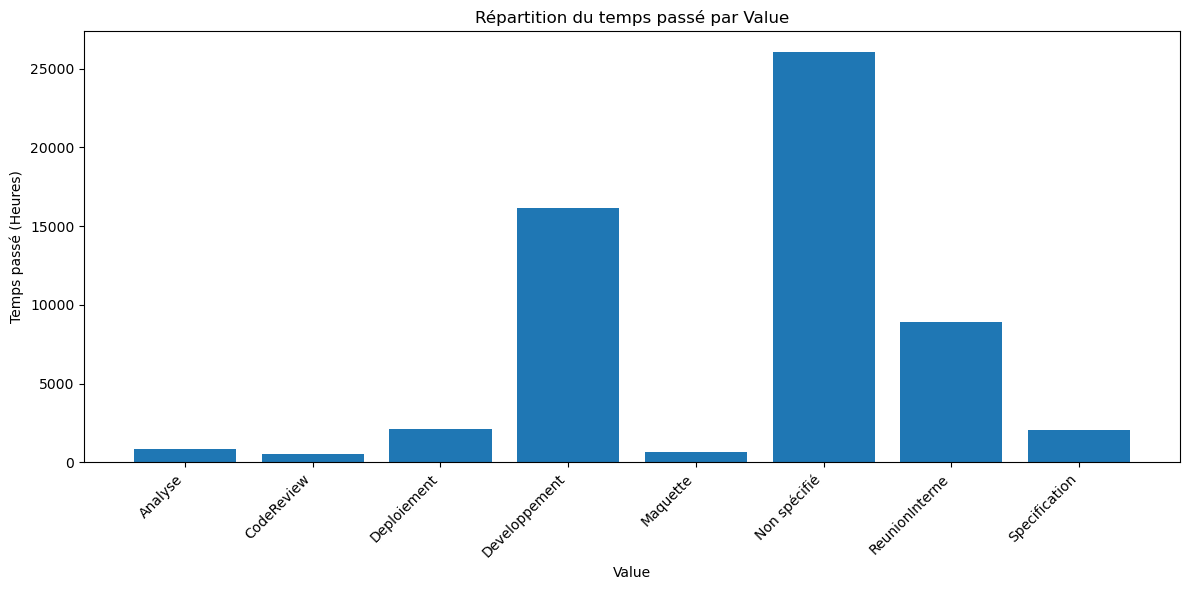

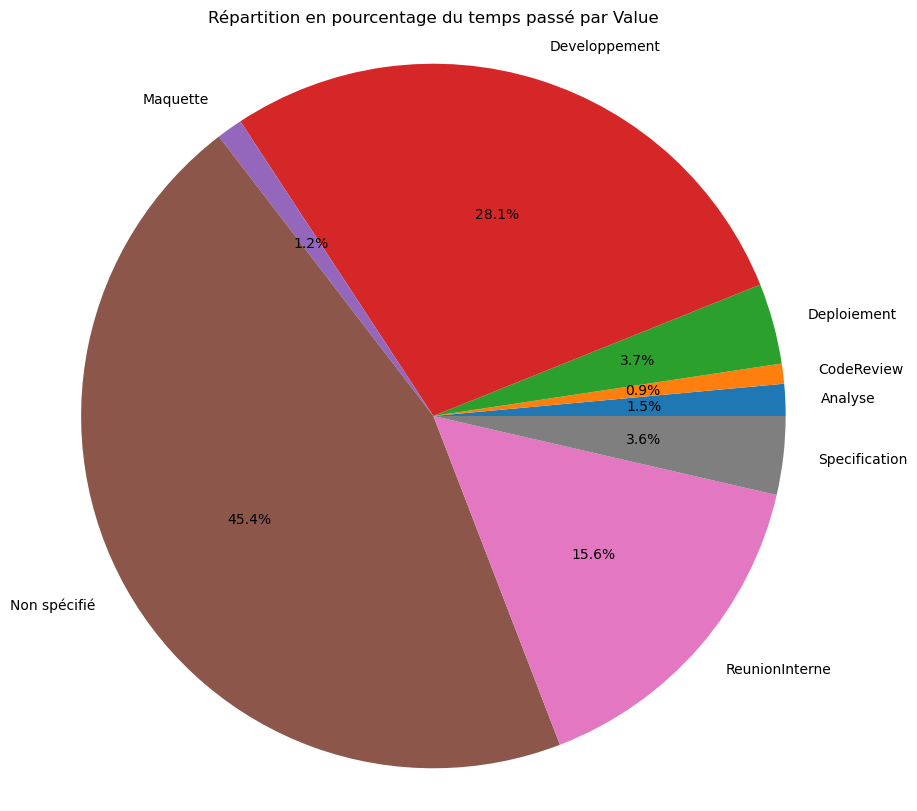

In [248]:
# Créer un graphique à barres
plt.figure(figsize=(12, 6))
plt.bar(repartition_globale['value'], repartition_globale['Total Time Spent (Heures)'])
plt.title('Répartition du temps passé par Value')
plt.xlabel('Value')
plt.ylabel('Temps passé (Heures)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Créer un graphique en camembert pour les pourcentages
plt.figure(figsize=(10, 10))
plt.pie(repartition_globale['Pourcentage'], labels=repartition_globale['value'], autopct='%1.1f%%')
plt.title('Répartition en pourcentage du temps passé par Value')
plt.axis('equal')
plt.show()

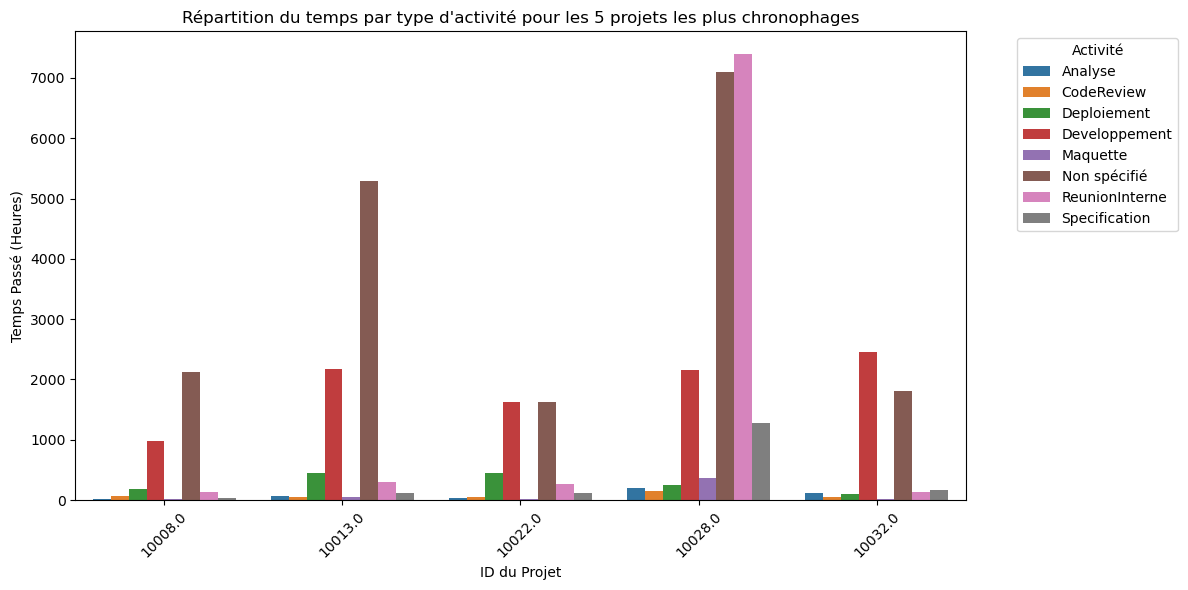

In [249]:
# Sélectionner les 5 projets dont le temps passé est le plus élevé
top_projects = temps_value_par_projet.groupby('id_project')['Total Time Spent (Heures)'].sum().nlargest(5).index

# Filtrer le df pour ces projets
df_top = temps_value_par_projet[temps_value_par_projet['id_project'].isin(top_projects)]

# Visualisation raphique à barres empilées
plt.figure(figsize=(12, 6))
sns.barplot(x='id_project', y='Total Time Spent (Heures)', hue='value', data=df_top)
plt.title('Répartition du temps par type d\'activité pour les 5 projets les plus chronophages')
plt.xlabel('ID du Projet')
plt.ylabel('Temps Passé (Heures)')
plt.xticks(rotation=45)
plt.legend(title='Activité', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
temps_value_par_projet.head()

In [ ]:
#Pourcentage de temps passé par type d'activité pour chaque projet
temps_value_par_projet['Pourcentage'] = temps_value_par_projet.groupby('id_project')['Total Time Spent (Heures)'].transform(lambda x: x / x.sum() * 100)

temps_value_par_projet.sort_values(['id_project', 'Pourcentage'], ascending=[True, False]).head(10)

In [ ]:
# Calculer la moyenne de temps passé par type d'activité à travers tous les projets
moyenne_globale = temps_value_par_projet.groupby('value')['Total Time Spent (Heures)'].mean().sort_values(ascending=False)

print("Moyenne de temps passé par type d'activité à travers tous les projets:")
print(moyenne_globale)

In [ ]:
#Analyse sans les value "Non spécifié" : DF filtré mais dans PowerBI, je pourrais faire le filtre
temps_value_par_projet_filtered = temps_value_par_projet[temps_value_par_projet['value'] != "Non spécifié"]
temps_value_par_projet_filtered

In [ ]:
tempo_projet['finalite_projet'].value_counts()